In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyedflib
import mne
import neurokit2 as nk2
import p_tqdm
from scipy.stats import trim_mean
from scipy import signal
from scipy.optimize import least_squares
import statsmodels.api as sm
from collections import defaultdict
import wfdb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor

In [2]:
#Desired Outcome..Preproccessed Data

result, fields = wfdb.rdsamp('x001')
header=fields['sig_name']
desired_result=pd.DataFrame(data=result, columns=header)

#Raw Data

s1_polar=pd.read_csv('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_POLAR.hrm', 
                     on_bad_lines='skip', names=['R-R Interval (ms)'])

edf_HX = mne.io.read_raw_edf('x001_HX.edf')
edf_HX=edf_HX.to_data_frame()

edf_NEXUS=mne.io.read_raw_edf('x001_NEXUS.edf')
edf_NEXUS_df=edf_NEXUS.to_data_frame()
edf_NEXUS_df['Sensor-B:EKG']=edf_NEXUS_df['Sensor-B:EEG']
edf_NEXUS_df=edf_NEXUS_df.drop(columns='Sensor-B:EEG') #Removing misnamed column

edf_SOT=mne.io.read_raw_edf('x001_SOT.edf')
edf_SOT_df=edf_SOT.to_data_frame()

edf_FAROS=mne.io.read_raw_edf('x001_FAROS.edf')
edf_FAROS_df=edf_FAROS.to_data_frame()

Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/x001_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
#Establish Reference Sensor...HexoSkin selected due to least amount of outliers. Seen later
reference_sensor=edf_HX.iloc[:,:2]

end_time=reference_sensor['time'].max()

#Drop Rows from other data sets that is extraneuous...i.e time that is greater than that of the reference sensor
edf_faros_df=edf_FAROS_df[edf_FAROS_df['time']<end_time]
edf_SOT_df=edf_SOT_df[edf_SOT_df['time']<end_time]

#Raw data
faros=edf_faros_df.iloc[:,:2]
SOT=edf_SOT_df[['time', 'EKG']]
NEXUS=edf_NEXUS_df

In [4]:
#Prepare lists

signals=[reference_sensor, NEXUS, SOT, faros]

reference_ecg=reference_sensor['4113:ECG_I']
NEXUS_ecg=NEXUS['Sensor-B:EKG']
SOT_ecg=SOT['EKG']
faros_ecg=faros['ECG']

ECGs=[reference_ecg, NEXUS_ecg, SOT_ecg, faros_ecg]
srs=[256, 256, 512, 1000]

time_1=reference_sensor['time']
time_2=NEXUS['time']
time_3=SOT['time']
time_4=faros['time']

In [5]:
unitless_signals=[]

for i,x in zip(ECGs, srs):
    b,a =signal.butter(3,(2.5,30), btype='bandpass', fs=x) #Gonna make it easier on myself and pass them all under the
    #same filter
    filtered = signal.filtfilt(b, a, i)
    unitless_signal= (filtered - np.mean(filtered)) / np.std(filtered)
    unitless_signals.append(unitless_signal)
    
    
reference_ecg=unitless_signals[0]
NEXUS_ecg=unitless_signals[1]
SOT_ecg=unitless_signals[2]
faros_ecg=unitless_signals[3]

In [6]:
annotations=[]
ecg_info=[]

for i,x in zip(unitless_signals, srs):
    ecg_df, info =nk2.ecg_process(i, sampling_rate=x)
    annotation=info['ECG_R_Peaks']
    annotations.append(annotation)
    ecg_info.append(ecg_df)

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


In [8]:
R_R_intervals = []
for i, x in zip(annotations, srs):
    diffs = np.diff(i) / x
    R_R_intervals.append(diffs)
    
reference_rr_intervals=R_R_intervals[0]
NEXUS_rr_intervals=R_R_intervals[1]
SOT_rr_intervals=R_R_intervals[2]
faros_rr_intervals=R_R_intervals[3]

In [7]:
def multi_sensor_alignment(reference_sensor, sensor_2, manual_shift=None):
    
    #Establish a reference window starting from the index in the middle of the reference signal
    mid_point=len(reference_sensor)//2
    reference_index=[mid_point-150, mid_point+150]
    start=reference_index[0]
    reference_window=range(start, start+300)
    
    #Find the minimum MAE for each possible window of across the sensors
    maes=[]
    window_length=300
    for i in range(1, len(sensor_2)):
        try:
            window=sensor_2[i:i+window_length]
            difference=abs(reference_sensor[reference_window]-window)
            mae=np.mean(difference)
            maes.append(mae)
        except:
            pass
    index=np.argmin(maes)
    
    #Establish Shift
    shift=(reference_window[0]-index)
    if manual_shift==None:
        pass
    if manual_shift!=None:
        shift=manual_shift
    
    #Develop Dataframe from Data and shift data accordingly
    df=pd.DataFrame(data=[reference_sensor, sensor_2]).T
    df[1]=df[1].shift(shift)
    
    aligned_signals=df
    
    
    #plot shifted data and OG data to see comparison
    fig,ax=plt.subplots(1,2)
    ax[0].plot(reference_sensor)
    ax[0].plot(sensor_2)
    ax[1].plot(df)
    plt.show()
    
    return aligned_signals, shift

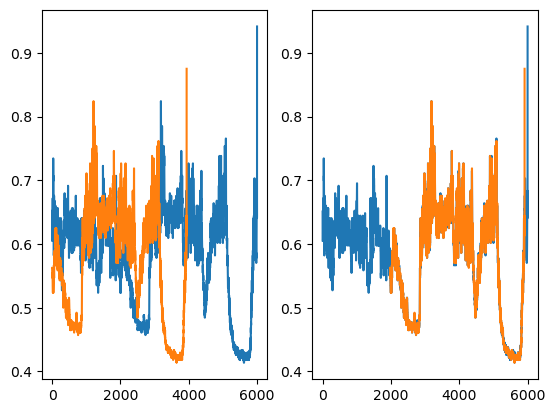

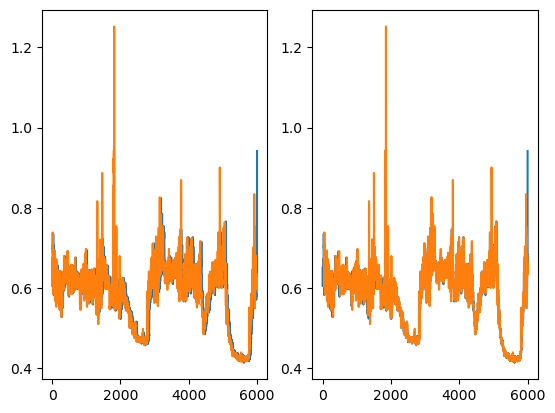

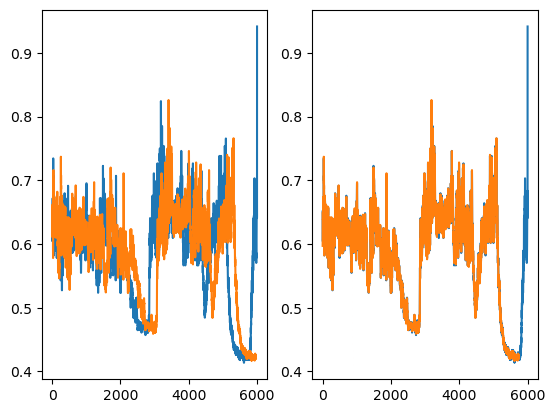

In [9]:
aigned_signals_ref_NEXUS, NEXUS_shift=multi_sensor_alignment(reference_rr_intervals, NEXUS_rr_intervals)
aigned_signals_ref_SOT, SOT_shift=multi_sensor_alignment(reference_rr_intervals, SOT_rr_intervals)
aigned_signals_ref_faros, faros_shift=multi_sensor_alignment(reference_rr_intervals, faros_rr_intervals)

In [10]:
aigned_signals_ref_NEXUS=aigned_signals_ref_NEXUS.rename(columns={0: 'Reference RR Intervals',
                               1: 'Nexus RR Intervals'})
aigned_signals_ref_SOT=aigned_signals_ref_SOT.rename(columns={1: 'SOT RR Intervals'})
aigned_signals_ref_faros=aigned_signals_ref_faros.rename(columns={1: 'faros RR Intervals'})

aigned_signals_ref_faros=aigned_signals_ref_faros.drop(columns=0)
aigned_signals_ref_SOT=aigned_signals_ref_SOT.drop(columns=0)

aligned_signals=pd.concat([aigned_signals_ref_NEXUS, aigned_signals_ref_SOT, aigned_signals_ref_faros], axis=1)

In [12]:
aligned_signals=aligned_signals.drop(index=5999)

In [13]:
aligned_signals

,Reference RR Intervals,Nexus RR Intervals,SOT RR Intervals,faros RR Intervals
0,0.605469,NaN,NaN,0.597
1,0.609375,NaN,NaN,0.605
2,0.621094,NaN,NaN,0.610
3,0.640625,NaN,NaN,0.620
4,0.644531,NaN,NaN,0.641
...,...,...,...,...
5994,0.683594,NaN,0.632812,NaN
5995,0.679688,NaN,0.636719,NaN
5996,0.675781,NaN,0.648438,NaN
5997,0.640625,NaN,0.636719,NaN


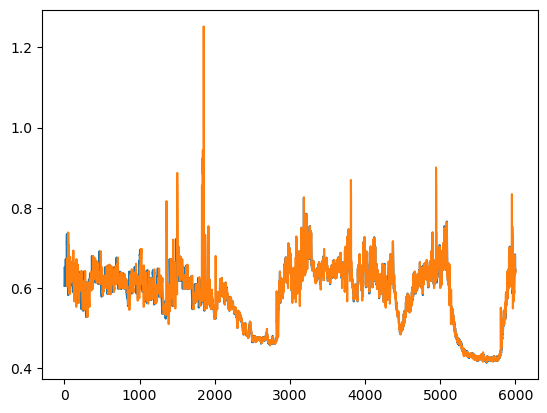

In [60]:
plt.plot(aligned_signals['Reference RR Intervals'])
plt.plot(aligned_signals['SOT RR Intervals'])

# Playing around with differences column and different ways to calculate differences and final result to see if I can find the best one

    solo_difference=df[col].diff()
    inter_difference=df[reference_rr]-df[target_sensor_rr]

In [15]:
aligned_signals['NEXUS solo_difference']=aligned_signals['Nexus RR Intervals'].diff()
aligned_signals['SOT solo_difference']=aligned_signals['SOT RR Intervals'].diff()
aligned_signals['faros solo_difference']=aligned_signals['faros RR Intervals'].diff()

aligned_signals['NEXUS inter_difference']=aligned_signals['Reference RR Intervals']-aligned_signals['Nexus RR Intervals']
aligned_signals['SOT inter_difference']=aligned_signals['Reference RR Intervals']-aligned_signals['SOT RR Intervals']
aligned_signals['faros inter_difference']=aligned_signals['Reference RR Intervals']-aligned_signals['faros RR Intervals']

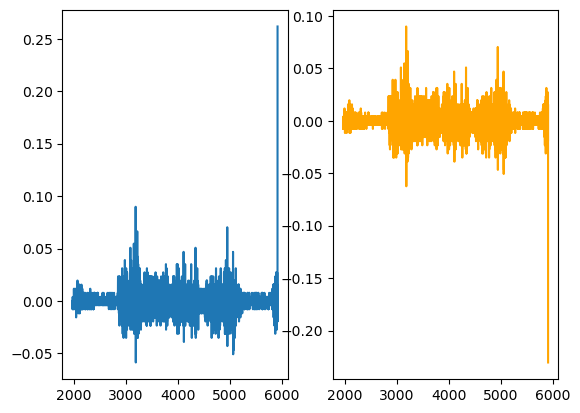

In [21]:
fig,ax=plt.subplots(1,2)
ax[0].plot(aligned_signals['NEXUS solo_difference'])
ax[1].plot(aligned_signals['NEXUS inter_difference'], color='orange')

 Very similar, only difference really appears to be direction of trail end
 
 -.05 seconds=50 milliseconds
 
 .25 seconds=250 milliseconds

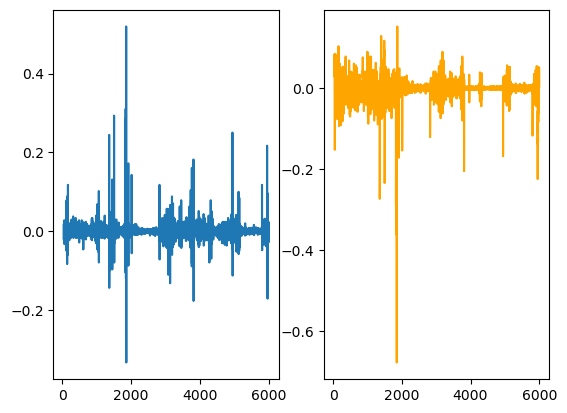

In [22]:
fig,ax=plt.subplots(1,2)
ax[0].plot(aligned_signals['SOT solo_difference'])
ax[1].plot(aligned_signals['SOT inter_difference'], color='orange')

 For SOT the difference appears to be more significant in the data. 
 
 Both the shape, the way the data bunches up, the min and max
 
 .2 seconds=200 milliseconds
 
 .4 seconds=400 milliseconds

In [33]:
aligned_signals['SOT inter_difference'].median()

0.0

In [31]:
aligned_signals['SOT solo_difference'].median()

0.0

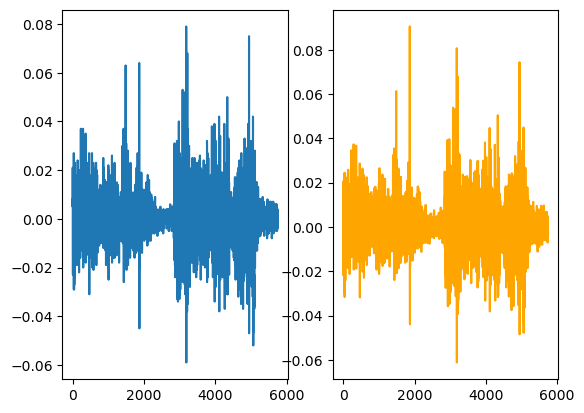

In [34]:
fig,ax=plt.subplots(1,2)
ax[0].plot(aligned_signals['faros solo_difference'])
ax[1].plot(aligned_signals['faros inter_difference'], color='orange')

 This one aligns really well like the Nexus
 
 .02 seconds=20 milliseconds
 
 .06 seconds=60 milliseconds

In [38]:
aligned_signals['faros solo_difference'].max()

0.07900000000000007

In [39]:
aligned_signals['faros inter_difference'].max()

0.09050000000000002

In [43]:
aligned_signals_subject_1=aligned_signals

In [44]:
aligned_signals

,Reference RR Intervals,Nexus RR Intervals,SOT RR Intervals,faros RR Intervals,NEXUS solo_difference,SOT solo_difference,faros solo_difference,NEXUS inter_difference,SOT inter_difference,faros inter_difference
0,0.605469,NaN,NaN,0.597,NaN,NaN,NaN,NaN,NaN,0.008469
1,0.609375,NaN,NaN,0.605,NaN,NaN,0.008,NaN,NaN,0.004375
2,0.621094,NaN,NaN,0.610,NaN,NaN,0.005,NaN,NaN,0.011094
3,0.640625,NaN,NaN,0.620,NaN,NaN,0.010,NaN,NaN,0.020625
4,0.644531,NaN,NaN,0.641,NaN,NaN,0.021,NaN,NaN,0.003531
...,...,...,...,...,...,...,...,...,...,...
5994,0.683594,NaN,0.632812,NaN,NaN,-0.007812,NaN,NaN,0.050781,NaN
5995,0.679688,NaN,0.636719,NaN,NaN,0.003906,NaN,NaN,0.042969,NaN
5996,0.675781,NaN,0.648438,NaN,NaN,0.011719,NaN,NaN,0.027344,NaN
5997,0.640625,NaN,0.636719,NaN,NaN,-0.011719,NaN,NaN,0.003906,NaN


In [61]:
test=aligned_signals['SOT RR Intervals']
y=test.dropna()
aligned_signals['Reference RR Intervals'][y.index]

35      0.718750
36      0.703125
37      0.699219
38      0.707031
39      0.683594
          ...   
5994    0.683594
5995    0.679688
5996    0.675781
5997    0.640625
5998    0.644531
Name: Reference RR Intervals, Length: 5964, dtype: float64

In [62]:
#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=2)

y=y
X_poly = poly_features.fit_transform(aligned_signals['Reference RR Intervals'][y.index].to_numpy().reshape(-1,1)) #Fit to reference signal

ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)
y_pred = ransac.predict(X_poly)

inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

residuals=y_pred-y

In [63]:
window_size=300 #Smoothing function to the predictions 
polyorder = 2
smoothed = signal.savgol_filter(y_pred, window_size, polyorder)

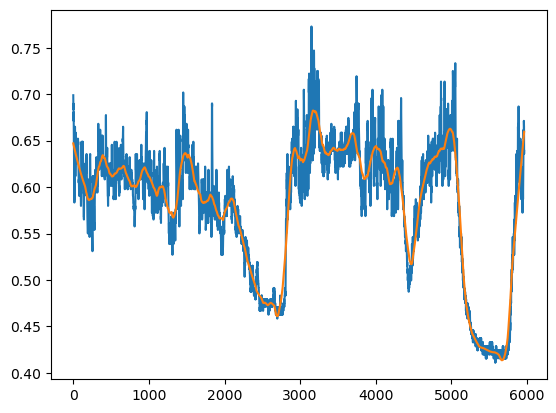

In [64]:
plt.plot(y_pred)
plt.plot(smoothed)

 So all the quadratic regressions look identical, likely because they align so well with HEXOSKIN

In [66]:
pd.Series(smoothed)

0       0.647057
1       0.646688
2       0.646321
3       0.645954
4       0.645589
          ...   
5959    0.656169
5960    0.657034
5961    0.657898
5962    0.658762
5963    0.659625
Length: 5964, dtype: float64

 These values are simply very similar to the RR intervals themselves, so they are definitely not the answer since the answer/final values we want are going to be applied to the original time to adjust it

In [68]:
aligned_signals['Reference Difference']=aligned_signals['Reference RR Intervals'].diff()

In [70]:
aligned_signals['Reference Difference']

0            NaN
1       0.003906
2       0.011719
3       0.019531
4       0.003906
          ...   
5994    0.023438
5995   -0.003906
5996   -0.003906
5997   -0.035156
5998    0.003906
Name: Reference Difference, Length: 5999, dtype: float64

 Since this is the reference sensor, this is essentially the CORRECT difference in the beat to beat intervals. There is obviously natural biological variation in the time of an RR interval. That is essentially what this column demonstrates

 So now that we have established what this reference difference is, which is the correct difference we are supposed to fit to it? The solo difference or the inter_difference?

 Solo difference would basically mean how different the other signals are from the accurate biological variation difference. This would essentially be the delay at a certain time point

 Inter_difference would be fitting the actual biological variation in RR intervals to the difference between actual RR interval and the produced RR interval??....I think solo would be correct then

In [82]:
test=aligned_signals['NEXUS solo_difference']
y=test.dropna()
aligned_signals['Reference Difference'][y.index]

1974   -0.007812
1975    0.003906
1976   -0.007812
1977    0.000000
1978    0.000000
          ...   
5907    0.011719
5908   -0.015625
5909   -0.015625
5910    0.015625
5911    0.015625
Name: Reference Difference, Length: 3938, dtype: float64

In [83]:
#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=2)

y=y
X_poly = poly_features.fit_transform(aligned_signals['Reference Difference'][y.index].to_numpy().reshape(-1,1)) #Fit to reference signal

ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)
y_pred = ransac.predict(X_poly)

inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

residuals=y_pred-y

In [84]:
window_size=300 #Smoothing function to the predictions 
polyorder = 2
smoothed_NEXUS = signal.savgol_filter(y_pred, window_size, polyorder)

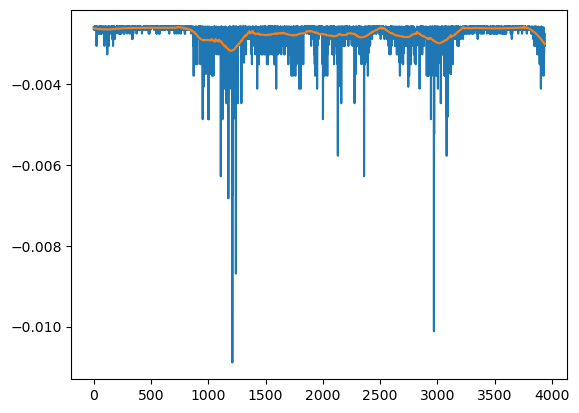

In [86]:
plt.plot(y_pred)
plt.plot(smoothed_NEXUS)

.008 seconds=8 milliseconds

In [114]:
test=aligned_signals['SOT solo_difference']
y=test.dropna()
aligned_signals['Reference Difference'][y.index]

36     -0.015625
37     -0.003906
38      0.007812
39     -0.023438
40      0.011719
          ...   
5994    0.023438
5995   -0.003906
5996   -0.003906
5997   -0.035156
5998    0.003906
Name: Reference Difference, Length: 5963, dtype: float64

In [115]:
#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=3)

y=y
X_poly = poly_features.fit_transform(aligned_signals['Reference Difference'][y.index].to_numpy().reshape(-1,1)) #Fit to reference signal

ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)
y_pred = ransac.predict(X_poly)

inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

residuals=y_pred-y

In [116]:
window_size=300 #Smoothing function to the predictions 
polyorder = 2
smoothed_SOT = signal.savgol_filter(y_pred, window_size, polyorder)

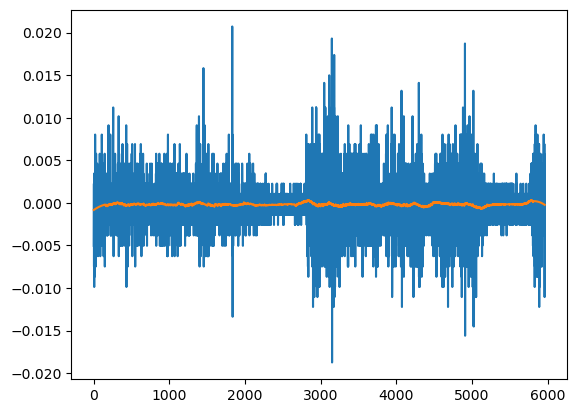

In [117]:
plt.plot(y_pred)
plt.plot(smoothed_SOT)

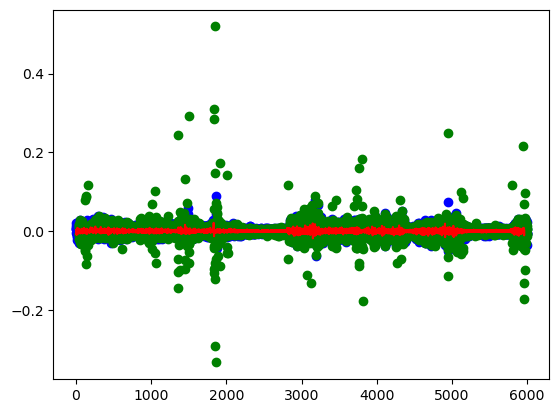

In [119]:
plt.scatter(x=aligned_signals.index, y=aligned_signals['Reference Difference'], color='blue')
plt.scatter(x=aligned_signals.index, y=aligned_signals['SOT solo_difference'], color='green')
plt.plot(y_pred, color='red')

In [88]:
test=aligned_signals['faros solo_difference']
y=test.dropna()
aligned_signals['Reference Difference'][y.index]

1       0.003906
2       0.011719
3       0.019531
4       0.003906
5       0.007812
          ...   
5740    0.003906
5741    0.003906
5742   -0.003906
5743    0.000000
5744   -0.003906
Name: Reference Difference, Length: 5744, dtype: float64

In [131]:
#Create polynomial feature transformer and fit to data
poly_features = PolynomialFeatures(degree=3)

y=y
X_poly = poly_features.fit_transform(aligned_signals['Reference Difference'][y.index].to_numpy().reshape(-1,1)) #Fit to reference signal

ransac = RANSACRegressor(random_state=0)
ransac.fit(X_poly, y)
y_pred = ransac.predict(X_poly)

inlier_reg = ransac.estimator_
intercept = inlier_reg.intercept_
coefficients = inlier_reg.coef_

residuals=y_pred-y

In [132]:
window_size=300 #Smoothing function to the predictions 
polyorder = 2
smoothed_faros = signal.savgol_filter(y_pred, window_size, polyorder)

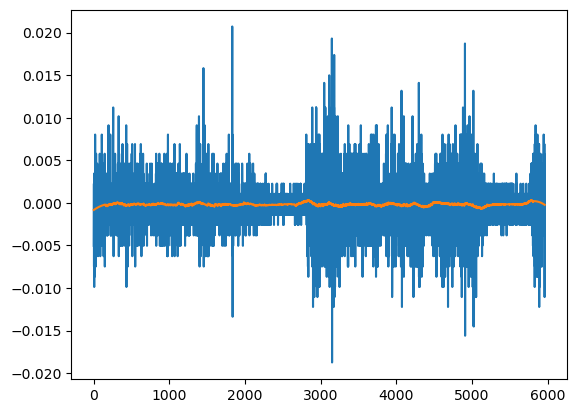

In [133]:
plt.plot(y_pred)
plt.plot(smoothed_faros)

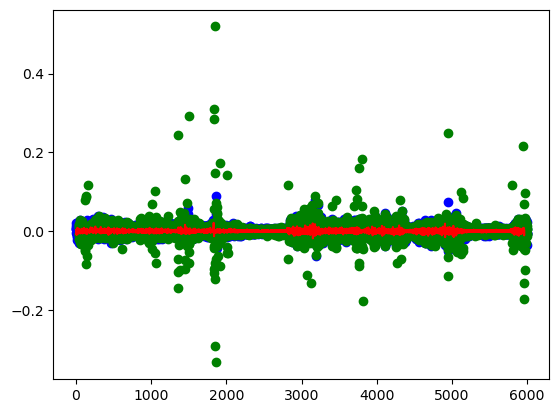

In [134]:
plt.scatter(x=aligned_signals.index, y=aligned_signals['Reference Difference'], color='blue')
plt.scatter(x=aligned_signals.index, y=aligned_signals['SOT solo_difference'], color='green')
plt.plot(y_pred, color='red')

In [139]:
smoothed_NEXUS.max()

-0.0025980614771372395

In [142]:
pd.Series(smoothed_SOT)[-20:]

5943   -0.000122
5944   -0.000127
5945   -0.000133
5946   -0.000138
5947   -0.000143
5948   -0.000149
5949   -0.000154
5950   -0.000160
5951   -0.000165
5952   -0.000171
5953   -0.000176
5954   -0.000182
5955   -0.000188
5956   -0.000193
5957   -0.000199
5958   -0.000205
5959   -0.000211
5960   -0.000217
5961   -0.000223
5962   -0.000229
dtype: float64